In [1]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    amazon-q-developer-jupyterlab-ext-3.4.3|     pyhd8ed1ab_0         240 KB  conda-forge
    amazon-sagemaker-jupyter-ai-q-developer-1.0.14|     pyhd8ed1ab_0          81 KB  conda-forge
    amazon-sagemaker-jupyter-scheduler-3.1.7|     pyhd8ed1ab_0         169 KB  conda-forge
    amazon_sagemaker_sql_editor-0.1.13|     pyhd8ed1ab_0        17.0 MB  conda-forge
    fastapi-0.115.4            |     pyhff2d567_1          72 KB  conda-forge
    ipython-8.29.0             |     pyh707e725_0         585 KB  conda-forge
    jupyter-ai-2.28.0          |     pyhd8ed1ab_0         739 KB  conda-forge
    jupyter-ai-magics-2.28.0   |     pyhd8ed1ab_0          35 KB  conda-forge
    jupyter-coll

In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install s3fs

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-scheduler 2.9.0 requires fsspec==2023.6.0, but you have fsspec 2024.10.0 which is incompatible.
amazon-sagemaker-jupyter-ai-q-developer 1.0.14 requires sagemaker-jupyterlab-extension-common<1,>=0.1.27, but you have sagemaker-jupyterlab-extension-common 0.1.24 which is incompatible.


In [3]:
default_bucket = "sagemaker-studio-820242935322-ss8mw03qe6n"

In [7]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-11-11 11:00:09.376 default:136 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [12]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

In [13]:
import boto3
import pandas as pd
import numpy as np

## Preprocess the dataset
def preprocess_data(file_path):  
  df = pd.read_excel(file_path)
  ## Convert to datetime columns
  df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
  df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
  ## Drop Rows with null values
  df = df.dropna()    
  ## Create Column which gives the days between the last order and the first order
  df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
  ## Create Column which gives the days between when the customer record was created and the first order
  df['created'] = pd.to_datetime(df['created'])
  df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
  ## Drop Columns
  df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
  ## Apply one hot encoding on favday and city columns
  df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
  return df

## Set the required configurations
model_name = "churn_model"
env = "dev"
## Preprocess the dataset
storedata = preprocess_data(f"s3://{default_bucket}/storedata_total.xlsx")

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [14]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [15]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

In [16]:
feature_names,train,validation,test = split_datasets(storedata)

In [17]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

In [18]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",content_type="csv")

In [19]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [25]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m5.2xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

In [26]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [27]:
objective_metric_name = "validation:auc"

In [28]:
tuner = HyperparameterTuner(
    estimator,objective_metric_name,hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [29]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................!


In [30]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [31]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [32]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 11, 11, 11, 18, 24, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9811530113220215},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 11, 11, 11, 18, 58, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-north-1:820242935322:training-job/sagemaker-xgboost-241111-1114-008-08d87d85',
 'TrainingJobName': 'sagemaker-xgboost-241111-1114-008-08d87d85',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 11, 11, 11, 18, 29, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.9245168974968203',
                          'eta': '0.12095358889700425',
                          'max_depth': '4',
                          'min_child_weight': '6.052925813592647'}}


In [33]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [34]:
best_hyperparameters

{'alpha': '1.9245168974968203',
 'eta': '0.12095358889700425',
 'max_depth': '4',
 'min_child_weight': '6.052925813592647'}

In [35]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [36]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [37]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [38]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-11-11-11-40-10-045


In [39]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress


In [40]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-north-1:820242935322:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-e7380b79',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 90 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2024, 11, 11, 11, 42, 56, 590000, tzinfo=tzlocal())}]

In [41]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-11-11 11:50:10.166 default:136 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-820242935322-ss8mw03qe6n/debugger/demo-smdebug-xgboost-churn-classificati-2024-11-11-11-40-10-045/debug-output


In [42]:
trial.tensor_names()

[2024-11-11 11:50:23.308 default:136 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-11 11:50:24.321 default:136 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [43]:
trial.tensor("average_shap/f1").values()


{0: array([0.], dtype=float32),
 5: array([0.00014763], dtype=float32),
 10: array([0.00357667], dtype=float32),
 15: array([0.00889084], dtype=float32),
 20: array([0.00443459], dtype=float32),
 25: array([0.00685865], dtype=float32),
 30: array([0.00272724], dtype=float32),
 35: array([-0.00326578], dtype=float32),
 40: array([0.0158328], dtype=float32),
 45: array([0.0261274], dtype=float32),
 50: array([0.03838749], dtype=float32),
 55: array([0.04666432], dtype=float32),
 60: array([0.04674627], dtype=float32),
 65: array([0.06320514], dtype=float32),
 70: array([0.07230587], dtype=float32),
 75: array([0.07798662], dtype=float32),
 80: array([0.07867534], dtype=float32),
 85: array([0.07564296], dtype=float32),
 90: array([0.08205055], dtype=float32),
 95: array([0.08941238], dtype=float32)}

In [44]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

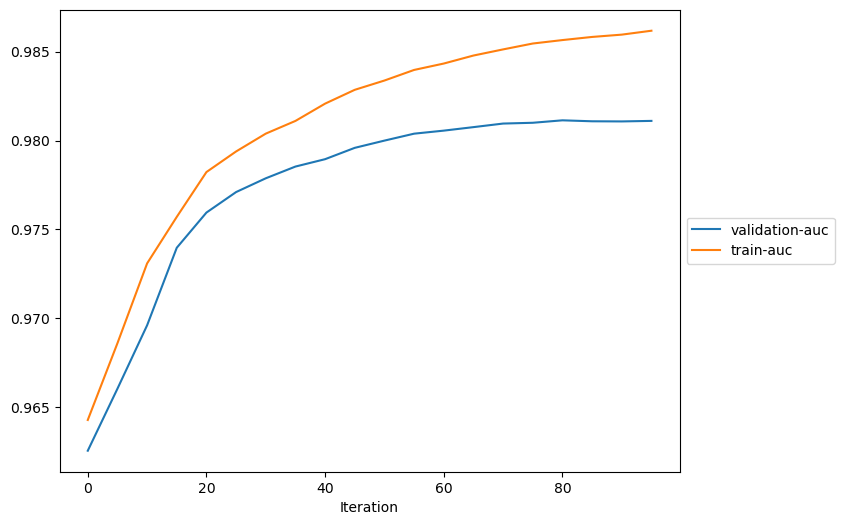

In [45]:
plot_collection(trial, "metrics")

In [46]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

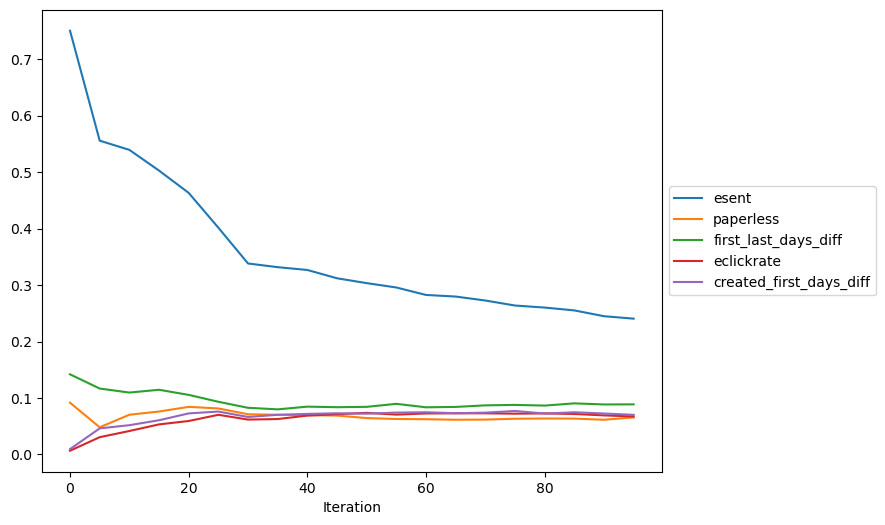

In [47]:
plot_feature_importance(trial, importance_type="cover")

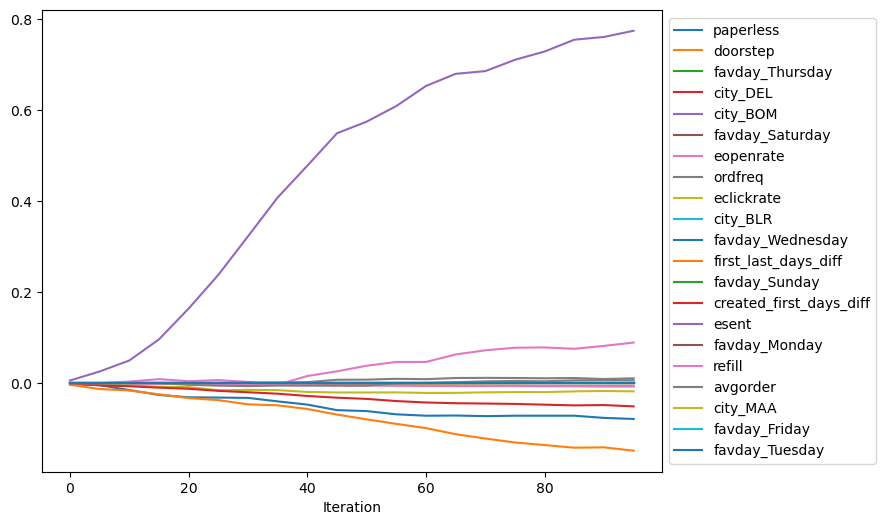

In [48]:
plot_collection(trial, "average_shap")

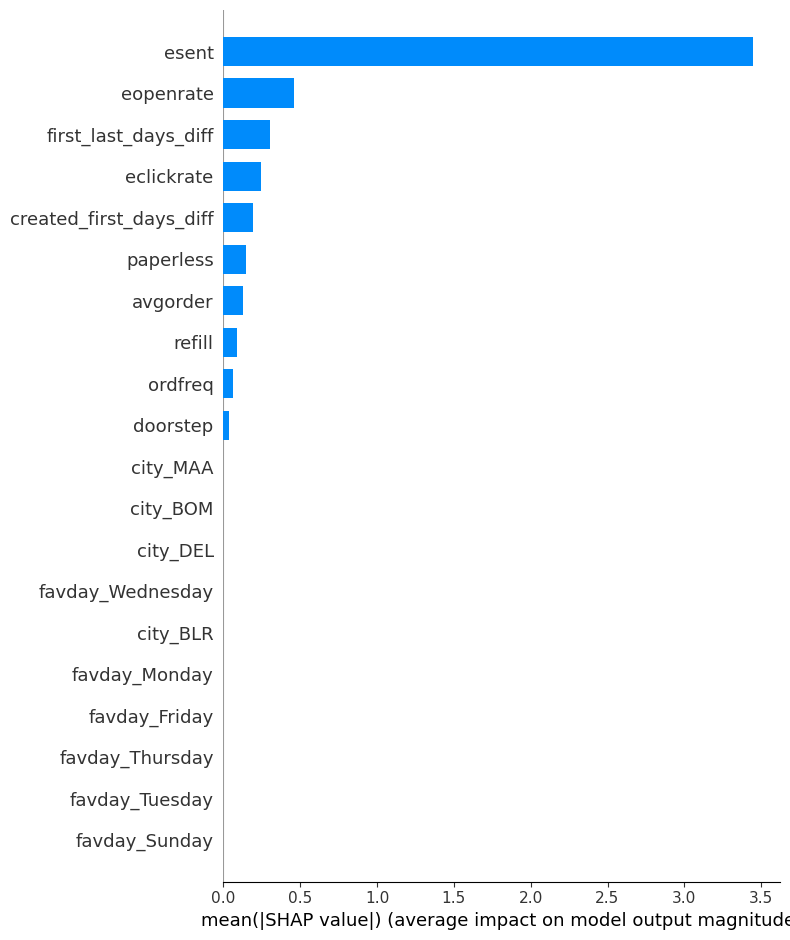

In [49]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [50]:
shap_base_value

2.0493574

In [51]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

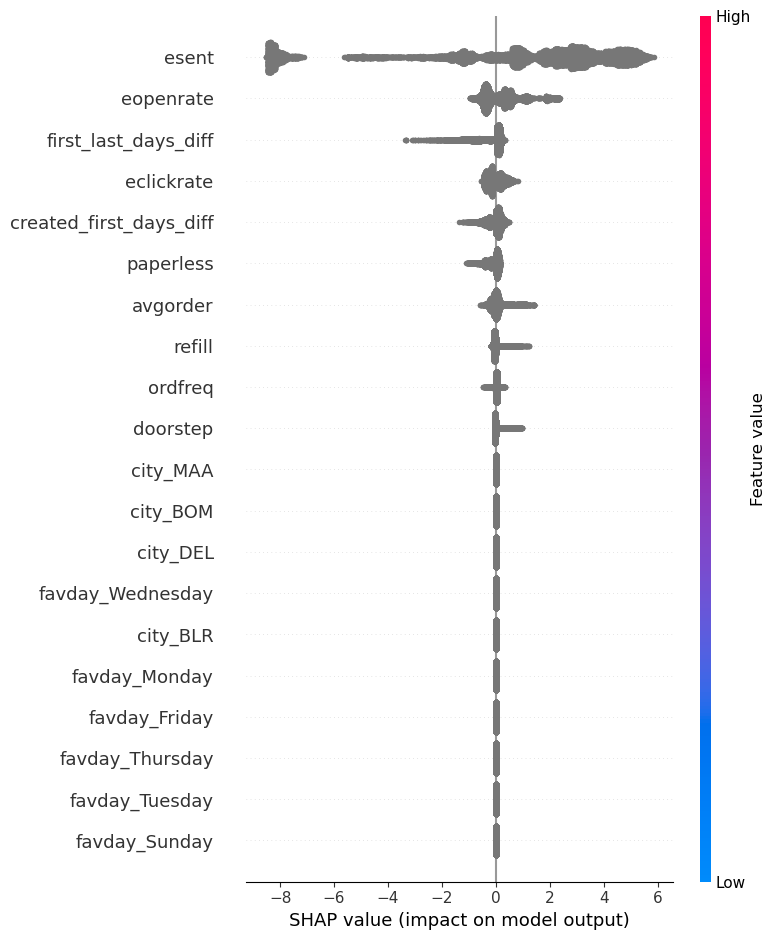

In [52]:
shap.summary_plot(shap_no_base, train_shap)

In [53]:
shap.initjs()

In [54]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [55]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [56]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)